<a href="https://colab.research.google.com/github/DaganItay/ItayDagan-projects/blob/main/control_1_tfIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files

# Upload the Excel file
#uploaded = files.upload()

#file_path = list(uploaded.keys())[0]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [10]:
n_of_programs_rows=0
programs_to_delete=["NaN"]

df=pd.read_excel('control.xlsx',sheet_name='control')
category_counts =df['Programs'].value_counts()

# Filter out categories with less than n occurrences
categories_to_keep = category_counts[(category_counts >= n_of_programs_rows) & (~category_counts.index.isin(programs_to_delete))].index
df = df[df['Programs'].isin(categories_to_keep)]

df['Programs'].value_counts()

Kedem                       7649
Barak                       4420
Yael                        1313
Hilla                        900
HP Indigo WS6X00             866
Ayala                        734
David                        314
Tamar                        248
Shani                        198
HP Indigo 30000              143
YMCK                         118
Ser 2,3 Products              97
PrintOS Press                 95
HP Indigo 7X00                93
HP Indigo 5x000 + 20000c      84
Technology roadmap/NBA        75
Blonde                        74
SAP & Finishing               50
HP Indigo 10000               50
Special Inks                  45
Ser 4                         39
Applications development      34
Ella                          33
Levana                        30
HP Indigo 8000                27
Security                      19
DFE Programs                  13
Dune                          13
GEM                            9
Hoshen                         7
HP Indigo 

In [11]:
column_types = {col: 'str' for col in df.columns if col != 'amount'}
column_types['amount'] = 'float'
df = df.astype(column_types)
df['CombinedText'] = df['Detail Comments'] + ' ' + df['PO Description'] + ' ' + df['Item Description']
df=df.drop(['Detail Comments','PO Description','Item Description'],axis=1)
label_encoder = LabelEncoder()
df['Programs'] = label_encoder.fit_transform(df['Programs'])

In [ ]:
df['Detail Comments']=df['Detail Comments'].astype(str)
df['PO Description']=df['PO Description'].astype(str)
df['Item Description']=df['Item Description'].astype(str)
df['CombinedText'] = df['Detail Comments'] + ' ' + df['PO Description'] + ' ' + df['Item Description']
df=df.drop(['Detail Comments','PO Description','Item Description'],axis=1)

df['Requester']=df['Requester'].astype(str)
df['Item']=df['Item'].astype(str)
df['Supplier Name']=df['Supplier Name'].astype(str)

df['amount']=df['amount'].astype(float)
df['Cost Center']=df['Cost Center'].astype(str)
df['GL Account']=df['GL Account'].astype(str)

label_encoder = LabelEncoder()
df['Programs'] = label_encoder.fit_transform(df['Programs'])

In [ ]:
# Split data into features (X) and target variable (y)
X = df.drop('Programs', axis=1)
y = df['Programs']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

# Define preprocessing for text, categorical, and numerical columns
#text_preprocessor = ('text', TfidfVectorizer(stop_words='english'), 'CombinedText')
#numeric_preprocessor = ('numeric', StandardScaler(), ['amount'])
text_preprocessor = ('text', TfidfVectorizer(stop_words='english', max_df=0.9), 'CombinedText')
categorical_preprocessor = ('categorical', OneHotEncoder(handle_unknown='ignore'), ['Requester','Item','Supplier Name', 'Cost Center','GL Account'])
numeric_preprocessor = ('numeric', SimpleImputer(strategy='constant', fill_value=0), ['amount'])

# Define column transformer to apply preprocessing to specific columns
preprocessor = ColumnTransformer(
    transformers=[
        text_preprocessor,
        categorical_preprocessor,
        numeric_preprocessor
    ],
    remainder='drop'  # Drop any columns not specified in transformers
)

model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=3)

# Create a pipeline to combine preprocessing and modeling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

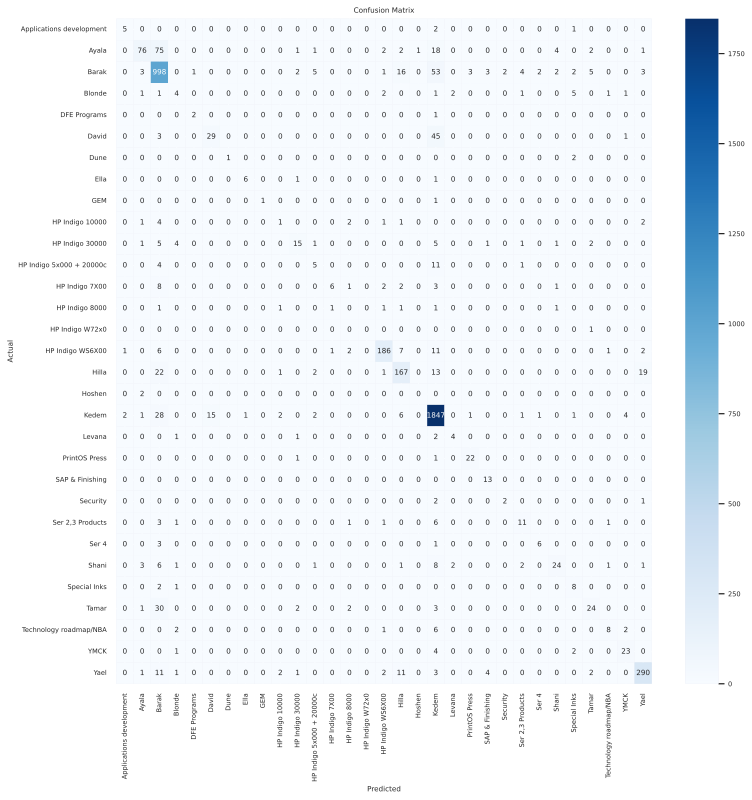

In [ ]:
# Inverse transform to get back the original categorical values

#y_test = label_encoder.inverse_transform(y_test)
#y_pred = label_encoder.inverse_transform(y_pred)

from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_test, y_pred)
sns.set(font_scale=0.6)  # You can adjust the scale according to your preference

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Calculate accuracy for each label
accuracy_per_label = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
accuracy_per_label['correct'] = accuracy_per_label['y_test'] == accuracy_per_label['y_pred']
accuracy_per_label = accuracy_per_label.groupby('y_test')['correct'].agg(['mean', 'count'])
accuracy_per_label['mean'] *= 100
accuracy_per_label = accuracy_per_label.sort_values(by='count', ascending=False)

# Display the results in a table format
print("Accuracy per label:")
print(accuracy_per_label)


Accuracy per label:
              mean  count
y_test                   
18       96.600418   1912
2        90.316742   1105
30       88.414634    328
16       74.222222    225
15       85.714286    217
1        41.530055    183
5        37.179487     78
27       38.709677     62
25       48.000000     50
10       41.666667     36
29       76.666667     30
20       91.666667     24
23       45.833333     24
12       26.086957     23
11       23.809524     21
28       42.105263     19
3        21.052632     19
21      100.000000     13
9         8.333333     12
26       72.727273     11
24       60.000000     10
19       50.000000      8
7        75.000000      8
0        62.500000      8
13        0.000000      7
22       40.000000      5
6        33.333333      3
4        66.666667      3
17        0.000000      2
8        50.000000      2
14        0.000000      1


UPLOAD NEW DATA

In [ ]:
df=pd.read_excel('itay.xlsx',sheet_name='itay')
# Combine the text from both columns
df['Detail Comments']=df['Detail Comments'].astype(str)
df['PO Description']=df['PO Description'].astype(str)
df['Item Description']=df['Item Description'].astype(str)
df['CombinedText'] = df['Detail Comments'] + ' ' + df['PO Description'] + ' ' + df['Item Description']
df=df.drop(['Detail Comments','PO Description','Item Description'],axis=1)

df['Requester']=df['Requester'].astype(str)
df['Item']=df['Item'].astype(str)
df['Supplier Name']=df['Supplier Name'].astype(str)

df['amount']=df['amount'].astype(float)
df['Cost Center']=df['Cost Center'].astype(str)
df['GL Account']=df['GL Account'].astype(str)

df=df[~df['Programs'].isin(programs_to_delete)]
df['Programs'] = label_encoder.transform(df['Programs'])

In [ ]:
df['Programs'].value_counts()

2     645
18    540
5     182
30    169
29    129
15     91
25     83
12     51
1      47
28     35
16     30
23     17
3      16
27     14
10     13
9      13
0       9
20      8
7       7
24      3
21      3
13      2
14      2
6       1
17      1
26      1
19      1
4       1
Name: Programs, dtype: int64

In [ ]:
X = df.drop('Programs', axis=1)
y = df['Programs']

# Make predictions on the test set
y_pred1 = pipeline.predict(X)

# Evaluate the model
accuracy = accuracy_score(y, y_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.8164616840113529


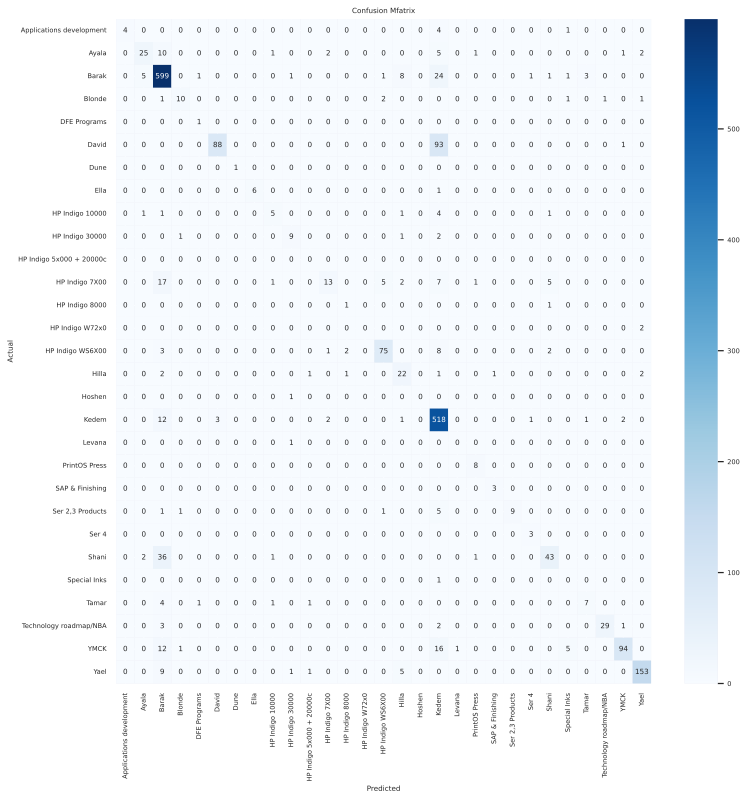

In [ ]:
# Inverse transform to get back the original categorical values

y = label_encoder.inverse_transform(y)
y_pred1 = label_encoder.inverse_transform(y_pred1)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
unique_labels = np.unique(np.concatenate((y, y_pred1)))

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix1 = confusion_matrix(y, y_pred1)
sns.set(font_scale=0.6)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Mfatrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#y_pred = label_encoder.inverse_transform(y_pred)
#y_test = label_encoder.inverse_transform(y_test)

# Calculate accuracy for each label
accuracy_per_label = pd.DataFrame({'y': y, 'y_pred1': y_pred1})
accuracy_per_label['correct'] = accuracy_per_label['y'] == accuracy_per_label['y_pred1']
accuracy_per_label = accuracy_per_label.groupby('y')['correct'].agg(['mean', 'count'])
accuracy_per_label['mean'] *= 100
accuracy_per_label = accuracy_per_label.sort_values(by='count', ascending=False)


# Display the results in a table format
print("Accuracy per label:")
print(accuracy_per_label)



Accuracy per label:
                                mean  count
y                                          
Barak                      92.868217    645
Kedem                      95.925926    540
David                      48.351648    182
Yael                       90.532544    169
YMCK                       72.868217    129
HP Indigo WS6X00           82.417582     91
Shani                      51.807229     83
HP Indigo 7X00             25.490196     51
Ayala                      53.191489     47
Technology roadmap/NBA     82.857143     35
Hilla                      73.333333     30
Ser 2,3 Products           52.941176     17
Blonde                     62.500000     16
Tamar                      50.000000     14
HP Indigo 30000            69.230769     13
HP Indigo 10000            38.461538     13
Applications development   44.444444      9
PrintOS Press             100.000000      8
Ella                       85.714286      7
Ser 4                     100.000000      3
SAP & Finish

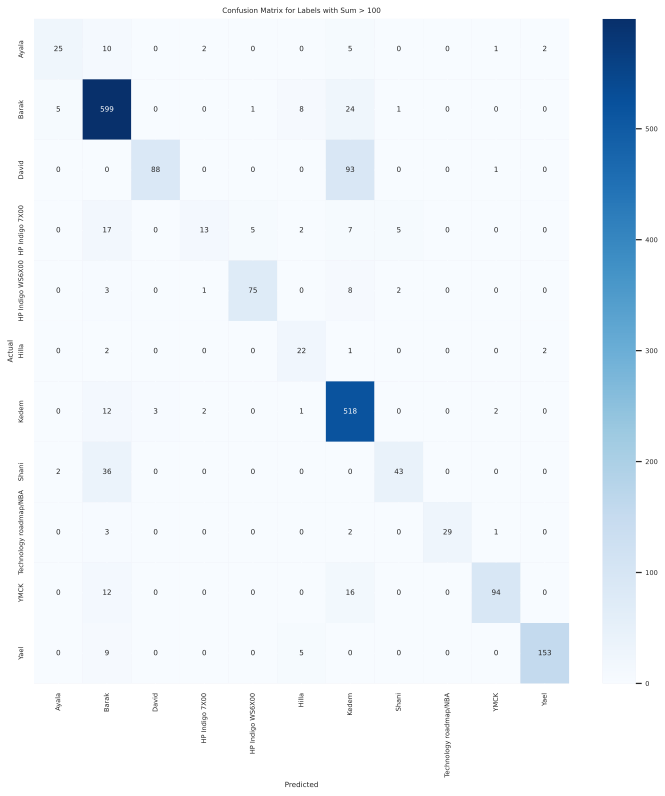

In [ ]:
# Inverse transform to get back the original categorical values
y = label_encoder.inverse_transform(y)
y_pred1 = label_encoder.inverse_transform(y_pred1)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix1 = confusion_matrix(y, y_pred1)

# Calculate the sum of occurrences for each label
label_sums = np.sum(conf_matrix1, axis=1)

# Filter labels based on the sum condition (e.g., greater than 100)
selected_labels = unique_labels[label_sums > 20]

# Get indices corresponding to selected labels
selected_indices = [np.where(unique_labels == label)[0][0] for label in selected_labels]

# Filter confusion matrix and unique labels
conf_matrix1_selected = conf_matrix1[selected_indices][:, selected_indices]
unique_labels_selected = selected_labels

sns.set(font_scale=0.6)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix1_selected, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels_selected, yticklabels=unique_labels_selected)
plt.title('Confusion Matrix for Labels with Sum > 100')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
